In [20]:
import pandas as pd
import joblib
import copy
import hashlib
import json
from datetime import datetime
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree

#### Log

In [21]:
def time_stamp():
    return datetime.now()

In [22]:
def create_log_template():
    logger = {
        'model_name' : [],
        'model_uid' : [],
        'training_time' : [],
        'training_date' : [],
        'performance' : [],
        'f1_score_avg' : [],
        'data_configurations' : [],
    }

    return logger

In [23]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, 'r') as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, 'w') as file:
            file.write('[]')
        file.close()
        with open(log_path, 'r') as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, 'w') as file:
        json.dump(last_log, file)
        file.close()

    return last_log

#### Training

In [24]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [25]:
list_of_model = {
        'smote' : [
        { 'model_name': lgr_baseline.__class__.__name__, 'model_object': lgr_baseline, 'model_uid': ''},
        { 'model_name': dct_baseline.__class__.__name__, 'model_object': dct_baseline, 'model_uid': ''},
        { 'model_name': rfc_baseline.__class__.__name__, 'model_object': rfc_baseline, 'model_uid': ''},
        { 'model_name': knn_baseline.__class__.__name__, 'model_object': knn_baseline, 'model_uid': ''},
        { 'model_name': xgb_baseline.__class__.__name__, 'model_object': xgb_baseline, 'model_uid': ''}
        ],
    }

In [26]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + '-' + model['model_name']

        start_time = time_stamp()
        model['model_object'].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model['model_object'].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model['model_uid'] = chiper_id

        logger['model_name'].append(model_name)
        logger['model_uid'].append(chiper_id)
        logger['training_time'].append(elapsed_time)
        logger['training_date'].append(str(start_time))
        logger['performance'].append(performance)
        logger['f1_score_avg'].append(performance['macro avg']['f1-score'])
        logger['data_configurations'].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [27]:
x_train = joblib.load('../data/processed/x_train.pkl') # menggunakan data yg sudah di standarisasi
y_train = joblib.load('../data/processed/y_train.pkl')

x_test = joblib.load('../data/processed/x_test.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

x_valid = joblib.load('../data/processed/x_valid.pkl')
y_valid = joblib.load('../data/processed/y_valid.pkl')

In [28]:
training_log, list_of_model_res = train_eval_model(
    list_of_model['smote'],
    'baseline_model',
    x_train,
    y_train,
    'smote',
    x_valid,
    y_valid,
    '../log/training_log.json'
)

  0%|          | 0/5 [00:00<?, ?it/s]/home/tanaka/ml_project_final/venv_mlproject/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [29]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(['f1_score_avg', 'training_time'], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [30]:
training_res = training_log_to_df(training_log)
training_res

100%|██████████| 1/1 [00:00<00:00, 680.34it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,26139f82e25985f0fe736f2652cc2a26,0.138059,2022-12-04 17:24:59.040456,"{'0': {'precision': 0.9368932038834952, 'recal...",0.930342,smote
1,baseline_model-KNeighborsClassifier,e8e4374585b8ad5d716423f3f647f061,0.033261,2022-12-04 17:25:01.371790,"{'0': {'precision': 0.9604005461993628, 'recal...",0.908902,smote
2,baseline_model-XGBClassifier,007f81ddb8dc7133cf00db93ae7c6b26,0.585586,2022-12-04 17:25:01.581666,"{'0': {'precision': 0.953081876724931, 'recall...",0.901262,smote
3,baseline_model-RandomForestClassifier,53f29c980fa3d5c465e89f9c8bbb6624,2.123755,2022-12-04 17:24:59.194441,"{'0': {'precision': 0.9526682134570765, 'recal...",0.898363,smote
4,baseline_model-LogisticRegression,4b774f4b2ca9fcab6caba38be64ed6c3,0.347836,2022-12-04 17:24:58.675215,"{'0': {'precision': 0.5683908045977012, 'recal...",0.733739,smote


In [31]:
training_res.loc[0]

model_name                         baseline_model-DecisionTreeClassifier
model_uid                               26139f82e25985f0fe736f2652cc2a26
training_time                                                   0.138059
training_date                                 2022-12-04 17:24:59.040456
performance            {'0': {'precision': 0.9368932038834952, 'recal...
f1_score_avg                                                    0.930342
data_configurations                                                smote
Name: 0, dtype: object

#### Training dg model terbaik

In [32]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier()

In [33]:
x_train

,temperature,humidity,tvoc,eco2,raw_h2,raw_ethanol,pressure,pm10
0,27.120000,47.370000,1228,405,12909,19428,938.728000,1.660000
1,15.890000,54.620000,0,400,13074,19971,939.747000,0.320000
2,-8.792000,51.420000,50,400,13232,20165,939.684000,2.180000
3,18.600000,54.980000,316,400,13107,19948,939.387000,0.360000
4,1.903000,48.940000,156,400,13214,20069,939.655000,1.610000
...,...,...,...,...,...,...,...,...
43007,18.126802,49.244925,11,400,13115,20014,939.661107,0.600640
43008,15.211347,51.899346,2,400,12996,19926,939.731163,0.288245
43009,26.569841,56.330484,0,400,13097,19998,939.720397,0.622540
43010,19.402662,52.310000,9,400,13216,20160,939.610000,1.170000


[Text(0.5330882352941176, 0.9545454545454546, 'pm10 <= 1.27\ngini = 0.5\nsamples = 43012\nvalue = [21506, 21506]'),
 Text(0.3088235294117647, 0.8636363636363636, 'tvoc <= 182.5\ngini = 0.26\nsamples = 25263\nvalue = [21384, 3879]'),
 Text(0.16176470588235295, 0.7727272727272727, 'temperature <= 1.506\ngini = 0.033\nsamples = 21443\nvalue = [21086, 357]'),
 Text(0.1323529411764706, 0.6818181818181818, 'gini = 0.0\nsamples = 184\nvalue = [0, 184]'),
 Text(0.19117647058823528, 0.6818181818181818, 'tvoc <= 147.5\ngini = 0.016\nsamples = 21259\nvalue = [21086, 173]'),
 Text(0.11764705882352941, 0.5909090909090909, 'tvoc <= 130.5\ngini = 0.003\nsamples = 19356\nvalue = [19331, 25]'),
 Text(0.058823529411764705, 0.5, 'tvoc <= 120.5\ngini = 0.0\nsamples = 18573\nvalue = [18571, 2]'),
 Text(0.029411764705882353, 0.4090909090909091, 'gini = 0.0\nsamples = 18222\nvalue = [18222, 0]'),
 Text(0.08823529411764706, 0.4090909090909091, 'raw_ethanol <= 20101.0\ngini = 0.011\nsamples = 351\nvalue = [349

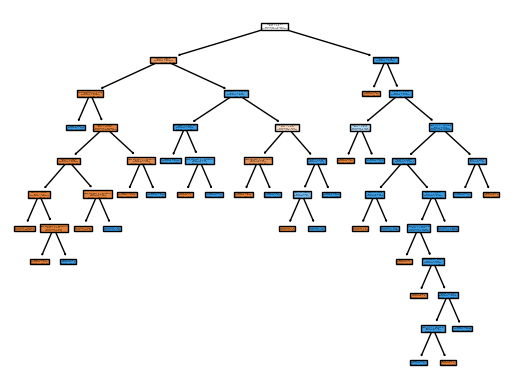

In [34]:
tree.plot_tree(dtc, filled=True, feature_names=dtc.feature_names_in_)

#### Evaluation

In [35]:
y_pred = dtc.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2681
           1       0.95      0.98      0.96      6713

    accuracy                           0.95      9394
   macro avg       0.94      0.92      0.93      9394
weighted avg       0.94      0.95      0.94      9394



In [36]:
y_pred = dtc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      2681
           1       0.94      0.98      0.96      6714

    accuracy                           0.94      9395
   macro avg       0.94      0.92      0.93      9395
weighted avg       0.94      0.94      0.94      9395



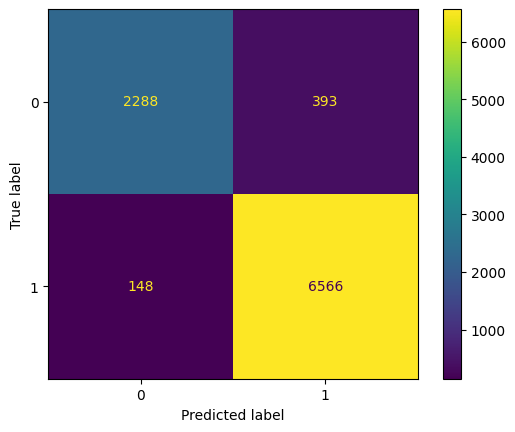

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

> dari hasil training model, terbaik adalah dg DecisionTree. model ini akan digunakan untuk production

In [38]:
joblib.dump(dtc, '../models/production_model.pkl')

['../models/production_model.pkl']